In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras import optimizers, applications
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import keras.backend as K

%matplotlib inline
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')
test.shape

(53576, 3)

In [3]:
#select only Private Label
test = test[test['Usage'] == 'Private']

In [4]:
test.shape

(42670, 3)

In [5]:
test['image'] = test['image'].apply(lambda x: x + '.jpg')

### Found imagens in dataset 2015

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = '../input/resized-2015-2019-blindness-detection-images/resized test 15',
    x_col = 'image',
    y_col= 'level',
    target_size = (224,224),
    batch_size = 1,
    shuffle = False,
    class_mode = None
)

Found 42670 validated image filenames.


In [7]:
step_size = test_generator.n // test_generator.batch_size

In [8]:
def test_models(model_name,models):
    
    preds_tta0 = []
    preds_tta1 = []
    preds_tta2 = []
    preds_tta3 = []
    preds_tta4 = []
    preds = []

        #model fold 0
    test_generator.reset()
    preds0 = xception0.predict_generator(generator=test_generator, steps=step_size)
    preds_tta0.append(preds0)

    #model fold 1
    test_generator.reset()
    preds1 = models[1].predict_generator(generator=test_generator, steps=step_size)
    preds_tta1.append(preds1)
   
        #model fold 2
    test_generator.reset()
    preds2 = models[2].predict_generator(generator=test_generator, steps=step_size)
    preds_tta2.append(preds2)

        #model fold 3
    test_generator.reset()
    preds3 = models[3].predict_generator(generator=test_generator, steps=step_size)
    preds_tta3.append(preds3)

        #model fold 4
    test_generator.reset()
    preds4 = models[4].predict_generator(generator=test_generator, steps=step_size)
    preds_tta4.append(preds4)
    
    print('------------------{}---------------------\n'.format(model_name))

    preds0 = sum(preds_tta0)
    preds1 = sum(preds_tta1)
    preds2 = sum(preds_tta2)
    preds3 = sum(preds_tta3)
    preds4 = sum(preds_tta4)

    filenames = test_generator.filenames
    
    results=pd.DataFrame({"id_code":filenames,
                      'diagnosis':test.level,
                        'pred0':preds0.argmax(axis=1),
                        'pred1':preds1.argmax(axis=1),
                        'pred2':preds2.argmax(axis=1),
                        'pred3':preds3.argmax(axis=1),
                        'pred4':preds4.argmax(axis=1)
                        })    

    print('FOLD 0: ',np.mean(np.equal(results.pred0, test['level'])))
    print('FOLD 1: ',np.mean(np.equal(results.pred1, test['level'])))
    print('FOLD 2: ',np.mean(np.equal(results.pred2, test['level'])))
    print('FOLD 3: ',np.mean(np.equal(results.pred3, test['level'])))
    print('FOLD 4: ',np.mean(np.equal(results.pred4, test['level'])))
    
    print('ENSEMBLE: ',np.mean(np.equal(results[['pred0','pred1']].mode(axis=1)[0], results['diagnosis'])))
    print('\n\n')
    labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
    cnf_matrix = confusion_matrix(test['level'].astype('int'), results[['pred0','pred1','pred2','pred3','pred4']].mode(axis=1)[0].astype('int'))
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(16, 7))
    plt.title(f'Confusion Matrix - {model_name}')
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()
    return results

In [9]:
#xception
xception0 = load_model('../input/models/new data/XCEPTION/Xception-f0-new.h5')
xception1 = load_model('../input/models/new data/XCEPTION/Xception-f1-new.h5')
xception2 = load_model('../input/models/new data/XCEPTION/Xception-f2-new.h5')
xception3 = load_model('../input/models/new data/XCEPTION/Xception-f3-new.h5')
xception4 = load_model('../input/models/new data/XCEPTION/Xception-f4-new.h5')

#inceptionresnetv2
inception0 = load_model('../input/models/new data/INCEPTIONRESNET/InceptionResNetV2-f0-new.h5')
inception1 = load_model('../input/models/new data/INCEPTIONRESNET/InceptionResNetV2-f1-new.h5')
inception2 = load_model('../input/models/new data/INCEPTIONRESNET/InceptionResNetV2-f2-new.h5')
inception3 = load_model('../input/models/new data/INCEPTIONRESNET/InceptionResNetV2-f3-new.h5')
inception4 = load_model('../input/models/new data/INCEPTIONRESNET/InceptionResNetV2-f4-new.h5')


#nasnetmobile
nasnet0 = load_model('../input/models/new data/NASNETMOBILE/NASNETMOBILE-f0-new.h5')
nasnet1 = load_model('../input/models/new data/NASNETMOBILE/NASNETMOBILE-f1-new.h5')
nasnet2 = load_model('../input/models/new data/NASNETMOBILE/NASNETMOBILE-f2-new.h5')
nasnet3 = load_model('../input/models/new data/NASNETMOBILE/NASNETMOBILE-f3-new.h5')
nasnet4 = load_model('../input/models/new data/NASNETMOBILE/NASNETMOBILE-f4-new.h5')

#efficientnetb0
eff0 = load_model('../input/models/new data/EFFICIENTNETB0/EfficientNetB0-f0-new.h5')
eff1 = load_model('../input/models/new data/EFFICIENTNETB0/EfficientNetB0-f1-new.h5')
eff2 = load_model('../input/models/new data/EFFICIENTNETB0/EfficientNetB0-f2-new.h5')
eff3 = load_model('../input/models/new data/EFFICIENTNETB0/EfficientNetB0-f3-new.h5')
eff4 = load_model('../input/models/new data/EFFICIENTNETB0/EfficientNetB0-f4-new.h5')


2022-11-10 13:37:23.977513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:37:24.077934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:37:24.078804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:37:24.080016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-11-10 13:39:41.261077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-10 13:39:42.783424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


------------------Xception---------------------

FOLD 0:  0.5117178345441762
FOLD 1:  0.6000937426763534
FOLD 2:  0.4785329271150691
FOLD 3:  0.4524255917506445
FOLD 4:  0.5247011952191235
ENSEMBLE:  0.6340988985235528





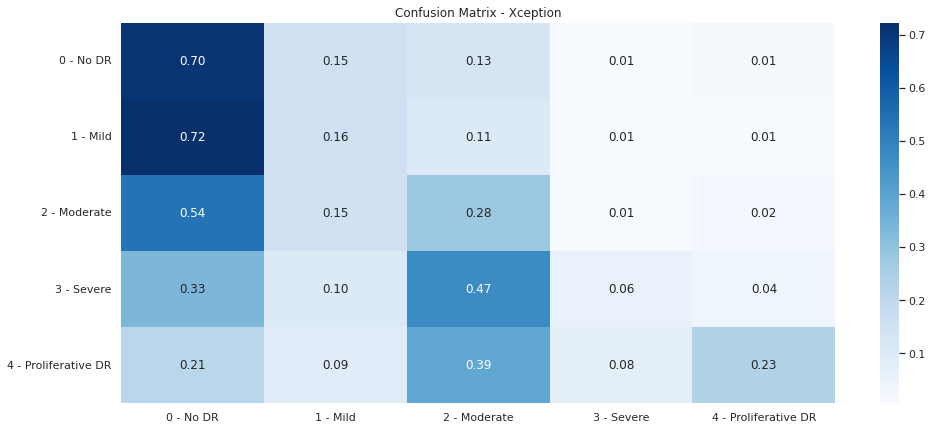

------------------InceptionResNetV2---------------------

FOLD 0:  0.5117178345441762
FOLD 1:  0.1806187016639325
FOLD 2:  0.3456526833841106
FOLD 3:  0.15198031403796577
FOLD 4:  0.4685727677525193
ENSEMBLE:  0.5201078040778064





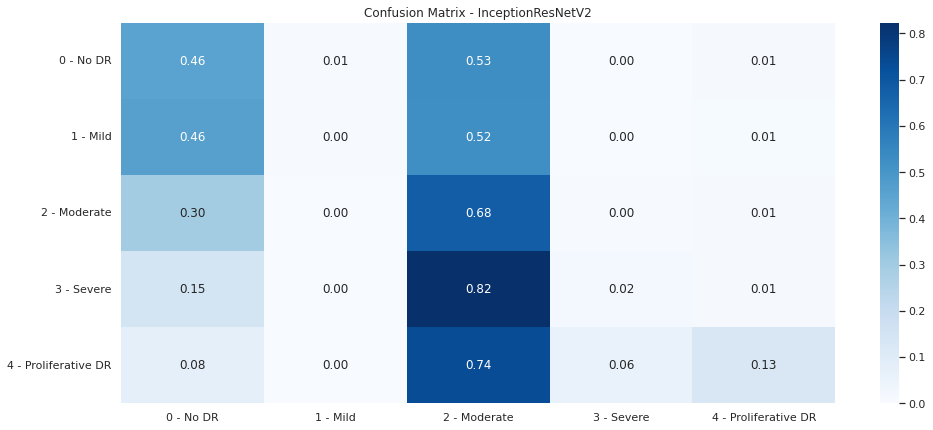

------------------NasNetMobile---------------------

FOLD 0:  0.5117178345441762
FOLD 1:  0.5149519568783689
FOLD 2:  0.5618701663932505
FOLD 3:  0.5325287086946332
FOLD 4:  0.3428638387625967
ENSEMBLE:  0.6427466604171549





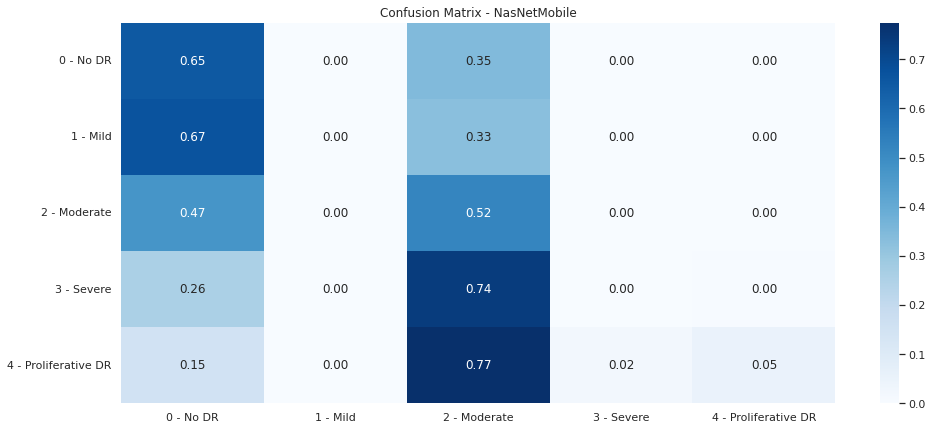

------------------EfficientNetB0---------------------

FOLD 0:  0.5117178345441762
FOLD 1:  0.7359503163815327
FOLD 2:  0.7359503163815327
FOLD 3:  0.7359503163815327
FOLD 4:  0.7359503163815327
ENSEMBLE:  0.7359503163815327





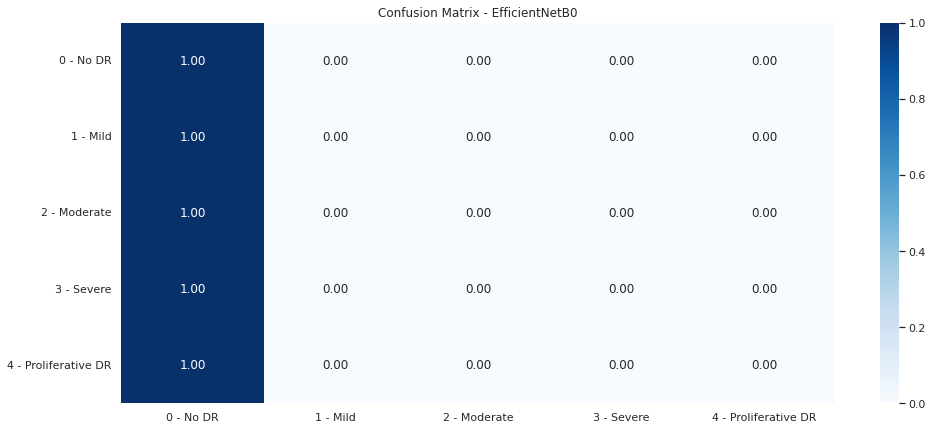

In [10]:
xception = [xception0,xception1,xception2,xception3,xception4]
xception = test_models('Xception',xception)

inception = [inception0,inception1,inception2,inception3,inception4]
inception = test_models('InceptionResNetV2', inception)

nasnet = [nasnet0,nasnet1,nasnet2,nasnet3,nasnet4]
nasnet = test_models('NasNetMobile', nasnet)

eff = [eff0,eff1,eff2,eff3,eff4]
eff = test_models('EfficientNetB0', eff)